## Сверточная нейронная сеть для выявления точек смены тенденции
Моделирование состоит из нескольких подзадач.
1. Необходимо научить сеть отличать тренды от флэтов (trend classification)
2. Необходимо научить сеть находить и распознавать объекты на большой картинке (detection). Это задача решается с помощью RCNN (Fast-RCNN, Faster R-CNN) или же методологии YOLO. 


Требуется серьезная адаптация к нашей задаче. Альтернативные варианты:

2a (option1)- научить сеть распознавать точки смены тенденции по картинкам, взятым за плюс/минус lag дней по смены тенденции - слишком высокий дисбаланс, сложно предсказать конкретный день.

2b (option2)-  научить сеть распознавать, содержится ли вообще на картинке точка смены тенденции, и если да - то где (в долях от ширины картинки). Задача ChangePoints classification + regression одновременно. Минусы - сложно настроить функцию потерь.

2с (option3)- показывать сети только картинки, содержащие точку смены тенденции и учить ее верно определять положение этой точки (в долях от ширины картинки). Только задача ChangePoints regression

2d (option4)- в дополнение к модели 2с надо научить сеть распознавать, содержится ли вообще на картинке точка смены тенденции. Это более легкая задача по сравнению с 2b, где надо было еще определять точку смены тенденции. Только задача ChangePoints classification.

Код ниже предназначен для решения задачи 2d.  На вход сверточной сети подаются матрицы, каждая из которых соответсвует некоторому срезу данных, описывающих n_days(берутся с шагом skip, чтобы контролировать объем выборки), в которых содержится или не содержится смена тенденции.  Мы научим сеть определять наличие или отсуствие смены тенденции в этом срезе данных, а  потому объединим с моделями, определяющей положение смены тенденции (если таковая была) и классифицирующей текущее состояние рынка (восходящий, нисходящий тренд и отсутсвие тренда).

In [6]:
#загрузка нужных библиотек (встроенные библиотеки Анаконды)
import pandas as pd
import numpy as np
import os
import time
#import datetime as dt
from __future__ import print_function
from __future__ import division
from sklearn import metrics 
from scipy import stats
#from sklearn import linear_model
#from sklearn import ensemble, metrics 
#from sklearn import ensemble, cross_validation, learning_curve, metrics 
#from sklearn.externals import joblib
#from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,RandomizedSearchCV

In [7]:
import matplotlib
matplotlib.use('agg')#этот бэкэнд нужен чтобы переводить картинки сразу в RGB-матрицу
from matplotlib import pyplot as plt #Источник pip install mpl_finance - раньше было частью matplotlib
from mpl_finance import candlestick2_ohlc#модуль для рисования графиков со свечами

In [8]:
#библиотека для работы со сверточными сетями
import cntk as C #Источник: https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python
#для работы CNTK требуется доустановка MKL-DNN - https://anaconda.org/anaconda/mkl-dnn
#прогресс бар для контроля исполнения кода (актуально для длинных расчетов)
import progressbar as pbar# Источник: https://anaconda.org/conda-forge/progressbar2
import trend_functions as trd #может потребоваться установка xgboost - https://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost

In [9]:
import warnings;warnings.simplefilter('once')

## Подготовка исходных данных
После предыдущих этапов у нас уже имеются файлы с очищенными данными и проставленными метками - например, файл NewAllChangePoints_ln_121017v2BB.csv (способ получения такого файла описывается в коде trenddetection_alfa. Для работы кода требутся функции join_files,ChangePoints_preprocess (точнее- только UnknownToFlat,fill_trigger_by_idselect, add_direction,move_triggers)

Из этих данных нам нужны только стобцы с датами, ценой закрытия, идентификатором окна и меткой (восходящий и нисходящий тренд или отсутствие тренда)

In [10]:
#определяем источник данных
#path=os.path.join('C:/', 'Users', 'elzolotareva','Desktop','Alfa-Capital-VM')#виртуальная машина
path=os.path.abspath(os.curdir)#текущая папка
extention= "csv"#расширение, в котором сохранены файлы
# Определяем параметры для обучения модели
saveas="121017cnn_bb" 
# определяем, надо ли логарифмировать данные для обучения модели
logarithm=True
# если да, то прибавлем "_ln_" к метке saveas
ln="_ln_"if logarithm else ""
saveas=ln+saveas
mode="OUT" #для обучения моделей данные должны быть размеченными ("IN" - если нет)
#определяем параметры тестовой выборки
d_spl=""#по умолчанию
fraction =0.7#указывается пропорция, если мы делим выборку по дате
num_output_classes = 0 #меток класса нет вообще

In [ ]:
%%time
#загружаем данные (с логарифмами)
NewAllChangePoints=pd.read_csv(os.path.join(path, "NewAllChangePoints_ln_121017v2BB.csv"), header=0, sep=',',encoding='cp1251')

In [ ]:
#В сохраненном файле вместо значений  Open,High,Low находятся их отношения к цене закрытия (логарифмированной или нет)
#Чтобы восстановить исходные значения мы делаем обратное преобразование
#Этого можно избежать, если изначально работать с сырыми данными, а не с сохранненным файлом
num_cols=["Open_orig","High_orig","Low_orig","Close_orig", "Volume_orig"]
if logarithm: #для моделей, где использована разность логарифмов, а не частное
    NewAllChangePoints[num_cols]=np.exp(NewAllChangePoints[["Open","High","Low","Close","Volume"]])
else:    
    NewAllChangePoints[num_cols]=NewAllChangePoints["Open","High","Low","Close", "Volume"]
    
NewAllChangePoints["Open_orig"] =NewAllChangePoints["Open_orig"]*NewAllChangePoints["Close_orig"]
NewAllChangePoints["High_orig"] =NewAllChangePoints["High_orig"]*NewAllChangePoints["Close_orig"]
NewAllChangePoints["Low_orig"] =NewAllChangePoints["Low_orig"]*NewAllChangePoints["Close_orig"]

In [ ]:
#Отбираем только нужные колонки
CNN_Trends=NewAllChangePoints[["File_id","IDselect_tmp","Date","Open_orig","High_orig","Low_orig","Close_orig","NewTypeBool_sign",'NewTrigger']]
if logarithm: #если далее надо вернуться к логарифмам
    CNN_Trends[["Open_orig","High_orig","Low_orig","Close_orig"]]= np.log(CNN_Trends[["Open_orig","High_orig","Low_orig","Close_orig"]])
CNN_Trends.to_csv(os.path.join(path,"CNN_Trends_Triggers" +ln+".csv"),sep = ',', index = False,header=1,encoding='cp1251')   

In [6]:
#Если такой файл уже сохранен, то можно его загрузить
CNN_Trends=pd.read_csv(os.path.join(path, "CNN_Trends_Triggers" +ln+".csv"), header=0, sep=',',encoding='cp1251')

In [7]:
# приводим дату к формату даты
CNN_Trends["Date"]=pd.to_datetime(CNN_Trends['Date'], format="%Y/%m/%d")
#Сортируем по номерам файлов, номеру окна и дате
CNN_Trends.sort_values(['File_id',"IDselect_tmp","Date"], ascending=True, inplace=True)

In [8]:
date_split,train_set,test_set,actual_fraction=trd.date_split(CNN_Trends,fraction)

2005-01-28 00:00:00 2017-09-13 00:00:00 2014-10-20 00:00:00


In [9]:
#сбрасываем индексы на всякий случай, чтобы не было путаницы
train_set.reset_index(drop=True,inplace=True)
test_set.reset_index(drop=True,inplace=True)

In [10]:
def CNN_changes_preprocess_op4(input_set,Trigger_col,dpi,n_days, skip=1):
    
    """
    Принимает на вход массив котировок (input_set), в колонке Trigger_col содержится метка о смене тенденции,
    dpi - разрешение, с которым сохраняются картинки
    Возвращает CNN_data - массив из оцифрованных картинок с метками
    CNN_images - только оцифрованные картинки,CNN_labels - только метки,
    CNN_im_shape - размер одной картинки в формате "высота,ширина, количество каналов"
    CNN_lb_shape- размер одной метки
    """
    
    CNN_data={}
    CNN_images={}
    CNN_labels={}
    allfiles=list(input_set["File_id"].drop_duplicates())
    bar = pbar.ProgressBar(max_value=len(allfiles)).start() # Создаём новый progress bar
    CNN_im_shape=(0,0,0)
    CNN_lb_shape=1
    #каждая метка содержит 1 значение - была или нет смена тенденции
    
    t=0
    for f in allfiles:# перебираем все файлы
        TrendNew=input_set[input_set["File_id"]==f]
        start_ix=TrendNew.index[0]
        for start_ix in TrendNew.index[:-(n_days-1):skip]:
            ChangeWin=TrendNew.loc[start_ix:start_ix+n_days-1]
            date=str(ChangeWin.loc[start_ix+n_days-1, "Date"].date())
            
            #заполняем метки
            trigger=int(np.max(ChangeWin[Trigger_col]))# 1 если была смена тенденции, 0 -если нет
            CNN_labels[(f,date)]=trigger
            #отрисовываем картинку для каждого среза
            fig, ax = plt.subplots(dpi=dpi)# выбираем нужное разрешение
            plt.axis('off')#отключаем оси
            fig.tight_layout(pad=0)#убираем рамку
            #создаем график из свечей
            candlestick2_ohlc(ax,ChangeWin["Open_orig"],ChangeWin["High_orig"],ChangeWin["Low_orig"],ChangeWin["Close_orig"],
                                      colorup='b', colordown='r',width=1,alpha=1)#Цвета такие, чтобы в RGB было больше нулей
            fig.canvas.draw()#отрисовываем картинку
            #print(fig.canvas.get_width_height())

            #получаем из картинки матрицу RGB в виде вектора
            image_flat = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)

            #сохраняем размеры матрицы для картинки
            CNN_im_shape=fig.canvas.get_width_height()[::-1] + (3,) #кортеж: высота,ширина, количество каналов 

            #сохраняем в словарь картинку в виде матрицы с заданным размером
            CNN_images[f,date]= image_flat.reshape(CNN_im_shape)#превращаем в массив размером (height,width,3)

            #сохраняем в словарь данные - плоская картинка + метка 
            CNN_data[(f,date)]=np.hstack([image_flat,trigger])

            #сохраняем картинку в папку (необязательно, но так можно видеть, что вышло)
    #       plt.savefig(os.path.join(path,"change_images_op2_"+str(dpi)+"dpi_"+str(n_days)+"d",f+"_"+date+ln+str(CNN_labels[(f,date)])+'.png'), 
    #                             dpi=dpi,bbox_inches='tight',pad_inches=0,transparent=True)
            plt.close(fig)
            
        t+=1
        bar.update(t)
    bar.finish()
    return CNN_data,CNN_images,CNN_labels,CNN_im_shape,CNN_lb_shape

In [11]:
matplotlib.pyplot.close('all')

In [12]:
dpi=10
n_days=75
skip=25
# CNN_train,CNN_im_train,CNN_lab_train,CNN_shape_train,CNN_lb_train=CNN_changes_preprocess_op4(train_set.head(50000),"NewTrigger",dpi,n_days,skip)
# CNN_test,CNN_im_test,CNN_lab_test,CNN_shape_test,CNN_lb_test=CNN_changes_preprocess_op4(test_set.head(25000),"NewTrigger",dpi,n_days,skip)
CNN_train,CNN_im_train,CNN_lab_train,CNN_shape_train,CNN_lb_train =CNN_changes_preprocess_op4(train_set,"NewTrigger",dpi,n_days,skip)
CNN_test,CNN_im_test,CNN_lab_test,CNN_shape_test,CNN_lb_test =CNN_changes_preprocess_op4(test_set,"NewTrigger",dpi,n_days,skip)

100% (1341 of 1341) |#####################| Elapsed Time: 2:15:36 Time: 2:15:36
100% (1389 of 1389) |#####################| Elapsed Time: 1:04:47 Time: 1:04:47


In [13]:
train_size =np.array(list(CNN_train.values())).shape[0]
test_size =np.array(list(CNN_test.values())).shape[0]
if (CNN_shape_train==CNN_shape_test) and (CNN_lb_train==CNN_lb_test): 
    CNN_shape = CNN_shape_train
    CNN_lb=CNN_lb_train
else:raise Exception("Train and test have different shapes") 
print(np.array(list(CNN_train.values())).shape)
print(np.array(list(CNN_test.values())).shape)
print(CNN_shape)

(89110, 9217)
(36344, 9217)
(48, 64, 3)


In [14]:
def transpose_data(input_dic, output_dic):
    """
    Получает на вход два словаря  с инпутами  и аутпутами, соответсвующими одинаковым ключам
    В словарях для каждого ключа сохранена матрицам определенных размеров
    В этих матрицах надо инвертировать порядок измерений (для соответсвия требованиям СNTK), 
    а потом уплощить и сохранить в новый словарь
    Функция нужна из-за того,что в CNTK изменения задаются в обратном порядке
    """
    data_trans_flat={}
    for key in input_dic:
        input_trans_flat=np.transpose(input_dic[key]).flatten()
        output_trans_flat=np.transpose(output_dic[key]).flatten()
        data_trans_flat[key]=np.hstack((input_trans_flat,output_trans_flat))
    return data_trans_flat

In [15]:
def savetxt_chP_op2(filename, ndarray, label_len, norm=False):
    """
    Save the data files into a format compatible with CNTK text reader (формат CTF)
    Модификация для задачи предказания точек смены тенденции
    """
    
    
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving", filename )
        with open(filename, 'w') as f:
            for row in ndarray:
                row_str = row.astype(str)
                label_str = ' '.join(row_str[-label_len:])#последние label_len элемента в строке -метка
                if norm: 
                    feature_str= ' '.join((row[:-label_len]//255).astype(str))#все: кроме последних с разделителем " "
                else:feature_str = ' '.join(row_str[:-label_len])#все: кроме последних с разделителем " "      
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("File already exists", filename)

In [16]:
norm=True
norm_str="_norm" if norm else ""
train_file_name="Train_ChPop4_trans"+str(dpi)+"dpi_"+str(n_days)+"-"+str(skip)+"d_"+str(train_size)+norm_str+".txt"
test_file_name="Test_ChPop4_trans"+str(dpi)+"dpi_"+str(n_days)+"-"+str(skip)+"d_"+str(test_size)+norm_str+".txt"
CNN_train_trans=transpose_data(CNN_im_train,CNN_lab_train)
CNN_test_trans=transpose_data(CNN_im_test,CNN_lab_test)
savetxt_chP_op2(os.path.join(path, train_file_name), np.array(list(CNN_train_trans.values())),CNN_lb_train,norm)
savetxt_chP_op2(os.path.join(path, test_file_name), np.array(list(CNN_test_trans.values())), CNN_lb_train,norm)

Saving C:\Users\elzolotareva\Desktop\Alfa-Capital-VM\Train_ChPop4_trans10dpi_75-25d_89110_norm.txt
Saving C:\Users\elzolotareva\Desktop\Alfa-Capital-VM\Test_ChPop4_trans10dpi_75-25d_36344_norm.txt


## Загрузка данных в нужном формате

In [12]:
use_current=False
if not use_current:    
    CNN_lb = 1
    #dpi=60
    dpi=10
    CNN_shape=(int(dpi/10*48),int(dpi/10*64),3)
    #CNN_shape=(96, 128, 3)# 20 dpi
    #CNN_shape=(288,384,3)# 60 dpi
    norm=True
    n_days=25
    skip=25
    #В идеале размер выборки надо определять по файлу, но тогда его придется загрузить сначала
#     train_size=10258
#     test_size=5547
    #train_size=234 
    #test_size=136
#     train_size=4928
#     test_size=2404
#     train_size=47854
#     test_size=22336

#     train_size=2677
#     test_size=1267
#     train_size=108718
#     test_size=49436
#     train_size=30372
#     test_size=12147   
    #train_size=89110
    #test_size=36344
    #train_size=44358
    #test_size=18143
    #train_size=45692
    #test_size=19533
    
    
    norm_str="_norm" if norm else ""
    #train_file_name="Train_ChPop4_trans"+str(dpi)+"dpi_"+str(n_days)+"-"+str(skip)+"d_"+str(train_size)+norm_str+".txt"
    #test_file_name="Test_ChPop4_trans"+str(dpi)+"dpi_"+str(n_days)+"-"+str(skip)+"d_"+str(test_size)+norm_str+".txt"
    #train_file_name="Train_ChPop4_trans10dpi_75-25d_89110_norm_bragin.txt"
    #test_file_name="Test_ChPop4_trans10dpi_75-25d_36344_norm_bragin.txt"
    train_file_name="Train_ChPop4_trans10dpi_25-25d_91788_norm_bragin.txt"
    test_file_name="Test_ChPop4_trans10dpi_25-25d_39122_norm_bragin.txt"
print ("train_file_name", train_file_name)
print ("test_file_name", test_file_name)

train_file_name Train_ChPop4_trans10dpi_25-25d_91788_norm_bragin.txt
test_file_name Test_ChPop4_trans10dpi_25-25d_39122_norm_bragin.txt


In [14]:
def file_len(fname):
    
    """Функция, определяющая количество строк в файле"""
    
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [15]:
#Учочним количество строк в обучающей и тестовой выборке
train_size=file_len(os.path.join(path, train_file_name))
test_size=file_len(os.path.join(path, test_file_name))
print ("train size: ", train_size)
print ("test size: ", test_size)

train size:  45692
test size:  19533


In [16]:
# Ensure the training and test data is available
data_found=False # A flag to indicate if train/test data found in local cache
train_file=os.path.join(path, train_file_name)
test_file=os.path.join(path, test_file_name)  
if os.path.isfile(train_file) and os.path.isfile(test_file): data_found=True
if not data_found:
    raise ValueError("Data not found")

In [18]:
# Фиксируем параметры, отвечающие за "случайность" для возможности воспроизведения результата
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

# Определяем размерность данных
input_dim_model = CNN_shape [::-1]  # В CNTK порядок изменрений обратный: число каналов, ширина, высота
input_dim = int(np.prod(CNN_shape)) # число элементов массива


In [19]:
def create_reader(path, is_training, input_dim, num_label_classes):
    
    """# Read a CTF formatted text using the CTF deserializer from a file"""
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

## Создание модели

In [20]:
x = C.input_variable(input_dim_model)
y = C.input_variable(CNN_lb)

C:\Users\elzolotareva\Anaconda3\lib\site-packages\cntk\default_options.py:89: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, _, _, _ = getargspec(function_or_class) if isfunction(function_or_class) else getargspec(function_or_class.__init__)


In [21]:
def create_model(features):
    
    """function to build model"""
    
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(25,25), 
                                       num_filters=8, 
                                       strides=(5,5), 
                                       pad=True, name='first_conv')(h)
#             h=C.layers.AveragePooling(filter_shape=(40,40), 
#                                       strides=(1,1),name="first_pool")(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                      pad=True, name='second_conv')(h)
#             h=C.layers.AveragePooling(filter_shape=(20,20), 
#                                       strides=(2,2),name="second_pool")(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=32, 
                                       strides=(1,1), 
                                       pad=True, name='third_conv')(h)
            #h = C.layers.Dense(4, activation=C.sigmoid, name='intermediate')(h)
            r = C.layers.Dense(CNN_lb, activation=C.sigmoid, name='classify')(h)
            return r

In [22]:
# Create the model
z = create_model(x)

# Print the output shapes / parameters of different components
print("Output Shape of the first convolution layer:", z.first_conv.shape)
# print("Output Shape of the first pooling layer:", z.first_pool.shape)
print("Output Shape of the second convolution layer:", z.second_conv.shape)
# print("Output Shape of the first pooling layer:", z.second_pool.shape)
print("Output Shape of the third convolution layer:", z.third_conv.shape)
#print("Output Shape of the intermediate dense layer:", z.intermediate.shape)
print("Output Shape of the  dense layer:", z.classify.shape)
print("Bias value of the last dense layer:", z.classify.b.value)

Output Shape of the first convolution layer: (8, 13, 10)
Output Shape of the second convolution layer: (16, 7, 5)
Output Shape of the third convolution layer: (32, 7, 5)
Output Shape of the  dense layer: (1,)
Bias value of the last dense layer: [0.]


C:\Users\elzolotareva\Anaconda3\lib\site-packages\cntk\default_options.py:89: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, _, _, _ = getargspec(function_or_class) if isfunction(function_or_class) else getargspec(function_or_class.__init__)


In [23]:
# Number of parameters in the network
C.logging.log_number_of_parameters(z)

Training 32177 parameters in 8 parameter tensors.


## Обучение модели

In [24]:
def fmeasure(output, target, beta=1):
    """
    This operation computes the f-measure between the output and target. If beta is set as one,
    its called the f1-scorce or dice similarity coefficient. f1-scorce is monotonic in jaccard distance.

    f-measure = (1 + beta ** 2) * precision * recall / (beta ** 2 * precision + recall)

    This loss function is frequently used in semantic segmentation of images. Works with imbalanced classes, for
    balanced classes you should prefer cross_entropy instead.
    This operation works with both binary and multiclass classification.

    Args:
        output: the output values from the network
        target: it is usually a one-hot vector where the hot bit corresponds to the label index
        beta: greater than one weights recall higher than precision, less than one for the opposite.
        Commonly chosen values are 0.5, 1 or 2.

    Returns:
        :class:`~cntk.ops.functions.Function`

    """

    assert len(target.shape) == len(output.shape)

    if len(output.shape) == 3:
        axis = (1, 2)  # assumes that the first axis is the class axis
    else:
        axis = None

    correct_predictions = C.reduce_sum(output * target, axis=axis)
    precision = correct_predictions / C.reduce_sum(output, axis=axis)
    recall = correct_predictions / C.reduce_sum(target, axis=axis)
    return 1 - (1 + beta ** 2) * precision * recall / (beta ** 2 * precision + recall)


In [26]:
def create_criterion_function(model, labels, balance=1):
    """Задание функции потерь и мертрики ошибки"""
 
    #penalty=balance if labels==1 else 1
   
    loss = -0.75*balance*labels*C.log(model)-(1-labels)*C.log(1-model)#взвешенная логистическая функция потерь
    #loss=-fmeasure(model, labels, beta=0.011)
    #detection_loss=C.losses.binary_cross_entropy(model[0], labels[0])*penalty
    
    #detection_loss=C.losses.binary_cross_entropy(model[0], labels[0])
    #detection_loss = -balance*labels[0]*C.log(model[0])-(1-labels[0])*C.log(1-model[0])#взвешенная логистическая функция потерь
    #detection_loss = -labels[0]*C.log(model[0])-(1-labels[0])*C.log(1-model[0])
    #detection_loss=C.losses.weighted_binary_cross_entropy(model[0], labels[0], [balance])
    #position_loss=C.squared_error(model[1], labels[1]) if labels[0]==1 else 0
    
    #loss = -2*labels*C.log(model)-(1-labels)*C.log(1-model)
    #loss=C.squared_error(model,labels)*(1-C.log(labels)-C.log(1-labels))
    #loss=C.squared_error(model,labels)*(-C.log(labels)-C.log(1-labels))
    #loss=C.squared_error(model,labels)
    #loss=abs(labels-model)/labels
    #loss=abs(labels-model)   
    #loss = detection_loss+position_loss
    
    errs =abs(labels-model)
    return loss, errs # (model, labels) -> (loss, error metric)

In [31]:
def print_training_progress(trainer, mb, frequency, verbose=1):
    
    """Defines a utility that prints the training progress"""
    
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

In [32]:
def train_test(train_reader, test_reader, model_func, test_size, train_size, 
               balance=1,learning_rate=0.001,norm=False,num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func if norm else model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y,balance)
    
    # Instantiate the trainer object to drive the model training
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    #m_schedule = C.momentum_schedule(0.95)
    #learner = C.adam(z.parameters, lr_schedule,m_schedule,unit_gain=True)
    #learner = C.adagrad(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = min(8, train_size)
    num_samples_per_sweep = train_size
    num_minibatches_to_train =(num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    print("num_minibatches_to_train:",num_minibatches_to_train)
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 1000
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size =min(512, test_size)
    num_samples =test_size
    num_minibatches_to_test = num_samples // test_minibatch_size
    
    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a trend image of 288*384*3 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

In [33]:
def find_balance(input_reader,size):
    
    """определяет дисбаланс выборки"""
    
    input_map = {x: input_reader.streams.features, y:input_reader.streams.labels} 
    data=input_reader.next_minibatch(size,input_map)
    gtlabel=data[y].asarray()[:,:,0]
    balance=gtlabel[gtlabel==0].shape[0]/ gtlabel[gtlabel==1].shape[0]
    return balance

In [34]:
# reader_train = create_reader(train_file, True, input_dim, CNN_lb)
# reader_test = create_reader(test_file, False, input_dim, CNN_lb)
# print ("Train_set_balance",find_balance(reader_train, train_size))
# print ("Test_set_balance",find_balance(reader_test, test_size))

In [35]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, CNN_lb)
    reader_test = create_reader(test_file, False, input_dim, CNN_lb)
    balance=find_balance(reader_train, train_size)
    print ("Train_set_balance",balance)
    #balance=1
    learning_rate = 0.001
    num_sweeps_to_train_with=10
    train_test(reader_train, reader_test, z,test_size, train_size,balance, learning_rate,norm,num_sweeps_to_train_with)
    
do_train_test()

C:\Users\elzolotareva\Anaconda3\lib\site-packages\cntk\default_options.py:89: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args, _, _, _ = getargspec(function_or_class) if isfunction(function_or_class) else getargspec(function_or_class.__init__)


Train_set_balance 9.115563427053354
num_minibatches_to_train: 57115.0
Minibatch: 0, Loss: 0.8140, Error: 55.68%
Minibatch: 1000, Loss: 0.5502, Error: 42.31%
Minibatch: 2000, Loss: 2.3892, Error: 48.65%
Minibatch: 3000, Loss: 0.5633, Error: 43.06%
Minibatch: 4000, Loss: 0.6274, Error: 46.59%
Minibatch: 5000, Loss: 1.9203, Error: 44.49%
Minibatch: 6000, Loss: 0.5417, Error: 41.73%
Minibatch: 7000, Loss: 1.1978, Error: 48.63%
Minibatch: 8000, Loss: 1.2625, Error: 42.54%
Minibatch: 9000, Loss: 1.2621, Error: 42.50%
Minibatch: 10000, Loss: 1.2280, Error: 45.23%
Minibatch: 11000, Loss: 0.5146, Error: 40.04%
Minibatch: 12000, Loss: 0.6009, Error: 44.91%
Minibatch: 13000, Loss: 1.9268, Error: 48.93%
Minibatch: 14000, Loss: 1.0651, Error: 40.01%
Minibatch: 15000, Loss: 0.5508, Error: 42.14%
Minibatch: 16000, Loss: 1.9921, Error: 44.87%
Minibatch: 17000, Loss: 1.1100, Error: 43.88%
Minibatch: 18000, Loss: 1.8598, Error: 45.41%
Minibatch: 19000, Loss: 1.1130, Error: 41.77%
Minibatch: 20000, Loss:

In [36]:
#print("Bias value  of the last dense layer:", z.classify.b.value)

## Предсказания

In [37]:
#out = C.softmax(z)
out=z

In [38]:
out.save(os.path.join(path, "CNN_ChP_trans_op4_23_bragin.model"))

In [ ]:
#out = C.Function.load(os.path.join(path, "CNN_ChP_trans_op3_3.model"))

In [39]:
# Read the data for evaluation
reader_eval=create_reader(test_file, False, input_dim, CNN_lb)

eval_minibatch_size =test_size#M
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

trd_label = data[y].asarray()
trd_data = data[x].asarray()

# reshape trd_data to: M x 3 (channel of color)x384 (image width) x 288 (image height)  to be compatible with model
trd_data = np.reshape(trd_data, tuple(np.hstack((eval_minibatch_size,input_dim_model))))
trd_label=trd_label.reshape(eval_minibatch_size,CNN_lb)
predicted_prob = np.array([out.eval(trd_data[i]) for i in range(len(trd_data))]).reshape(eval_minibatch_size,CNN_lb)

In [40]:
predicted_prob=predicted_prob.flatten()
trd_label=trd_label.flatten()

In [42]:
tresh=0.5
predictions=np.array(pd.Series(predicted_prob).apply(func = lambda x: 1 if x>=tresh else 0))
trd.validate_model(['NoChange','Change'],trd_label,predicted_prob,tresh)

Treshhold: 50.00%
             precision    recall  f1-score   support

   NoChange       0.90      0.80      0.85     17499
     Change       0.14      0.27      0.18      2034

avg / total       0.82      0.75      0.78     19533

Accuracy: 74.69%
AUC: 56.01%


('             precision    recall  f1-score   support\n\n   NoChange       0.90      0.80      0.85     17499\n     Change       0.14      0.27      0.18      2034\n\navg / total       0.82      0.75      0.78     19533\n',
 0.7468898786668714,
 0.5601037013886395)

In [45]:
print("Label    :", trd_label[:np.min([eval_minibatch_size,5])].flatten())
print("Predicted:", predictions[:np.min([eval_minibatch_size,5])].flatten())

Label    : [0. 0. 0. 0. 0.]
Predicted: [0 1 1 0 1]


In [46]:
tn,fp,fn,tp= metrics.confusion_matrix(trd_label, predictions).ravel()
print ("tn=",tn)
print ("fp=",fp)
print ("fn=",fn)
print ("tp=",tp)

tn= 14036
fp= 3463
fn= 1481
tp= 553


In [47]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[14036  3463]
 [ 1481   553]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.73 0.27]]


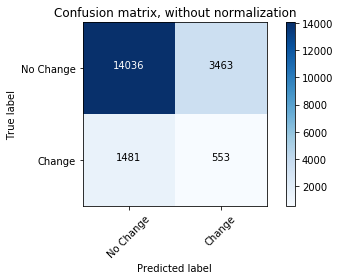

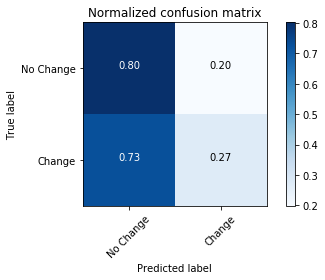

In [48]:
%matplotlib inline
# Compute confusion matrix
class_names=["No Change", "Change"]
cnf_matrix = metrics.confusion_matrix(trd_label, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Labels: DescribeResult(nobs=19533, minmax=(0.0, 1.0), mean=0.10413147, variance=0.09329288, skewness=2.592195987701416, kurtosis=4.719480448997193)


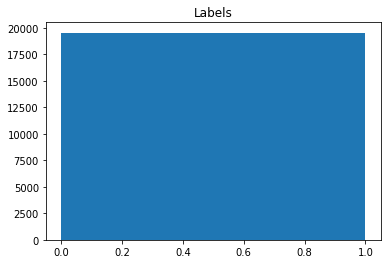

In [49]:
%matplotlib inline
plt.hist(trd_label, bins='auto')  # arguments are passed to np.histogram
plt.title("Labels")
print ("Labels:",stats.describe(trd_label))
plt.show()

Errors:  DescribeResult(nobs=19533, minmax=(-1.0, 1.0), mean=-0.10146930834997184, variance=0.24282653240069402, skewness=-0.22156418256310972, kurtosis=0.854295042397605)


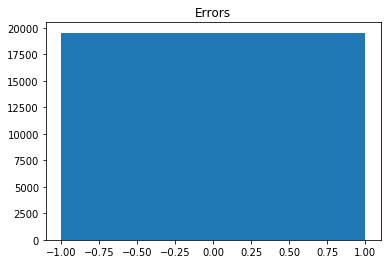

In [50]:
plt.hist(trd_label-predictions, bins='auto')  # arguments are passed to np.histogram
plt.title("Errors")
print ("Errors: ", stats.describe(trd_label-predictions))
plt.show()

In [51]:
if not norm: trd_data=trd_data/255

In [52]:
sample_number=0

Sample 0 Predicted Label:  0   Ground truth : 0.0


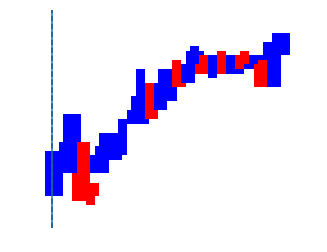

In [53]:
# Визуализация
# Берем случайное изображение
#for sample_number in range(17):
#sample_number = np.int(np.random.uniform(0,test_size-1))
%matplotlib inline

trd_gt, trd_pred = trd_label[sample_number], predictions[sample_number]
print("Sample", sample_number,"Predicted Label: ", trd_pred, "  Ground truth :",trd_gt )

plt.imshow(np.transpose(trd_data[sample_number].reshape(input_dim_model)))
#plt.subplots_adjust(bottom=0, top=1, left=0, right=1)
plt.axvline(x=5+predictions[sample_number]*(64-10.5), color='k', linestyle='--')
plt.axvline(x=5+trd_label[sample_number]*(64-10.5))

plt.axis('off')
sample_number+=1

In [54]:
errors=pd.Series(pd.Series(trd_label)!=pd.Series(predictions))
trd_errors=trd_data[errors]
pred_errors=np.array(predicted_prob)[errors]
gtlabel_errors=np.array(trd_label)[errors]
print ("Количество ошибок", trd_errors.shape[0])

Количество ошибок 4944


Predicted Label:  0.57289904   Ground truth : 0.0


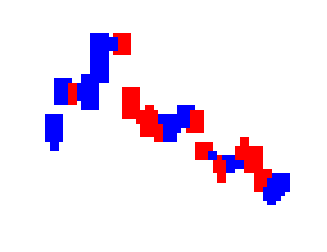

In [55]:
# # Берем случайное изображение
error_number = 3
%matplotlib inline

plt.imshow(np.transpose(trd_errors[error_number].reshape(input_dim_model)))#, cmap="gray_r")
plt.axis('off')

trd_gt, trd_pred = gtlabel_errors[error_number], pred_errors[error_number]

print("Predicted Label: ", trd_pred, "  Ground truth :",trd_gt)